# CGANs - Conditional Generative Adversarial Nets

Brief introduction to Conditional Generative Adversarial Nets or CGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training CGANs with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 3. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

* **Generator**: The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

* **Discriminator**: $x$ and $y$ are presented as inputs and to a discriminative function.

### Network Design

<img src="../../img/network_design_ccgan.png" width="600"> 


### Cost Funcion

$$ \underset{G}{min} \: \underset{D}{max} \; V_{CGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$


## 4. Training CGANs with MNIST dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator are the **normal distribution** $z$ and $y$. They are combined in joint hidden representation.
        * Embedding($y, z$).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The input to the discriminator are $x$ and $y$. They are combined in joint hidden representation.
        *  Embedding($y, x$).
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Embedding, multiply, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

---
#### Embedding layer background

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 2)           20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
[[0 1 2 3 4 5 6 7 8 9]]
[[[-0.0362522  -0.00915883]
  [ 0.00785043 -0.01360036]
  [-0.02930465 -0.04298828]
  [ 0.0146546  -0.03468901]
  [-0.03751612 -0.02600642]
  [ 0.01524777  0.00385109]
  [-0.04224639 -0.04078827]
  [-0.01043304 -0.01638323]
  [-0.04165388  0.01747418]
  [ 0.01249812  0.02900592]]]


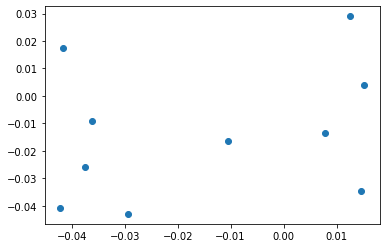

In [19]:
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=2))

model.summary()
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
print(input_array)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

#### Explore visual data

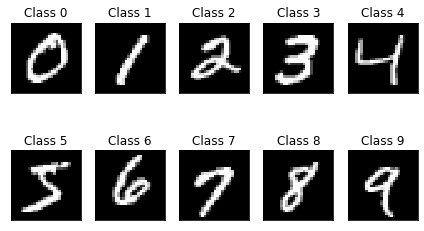

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [21]:
# print('X_train.shape', X_train.shape)
# print('y_train.shape', y_train.shape)

# reshaping the inputs
# X_train = X_train.reshape(60000, 28*28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# normalizing the inputs (-1, 1)
# X_train = (X_train.astype('float32') / 255 - 0.5) * 2
X_train = (X_train-127.5)/127.5

# print('X_train reshape:', X_train.shape)

In [7]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 2. Define model

#### Generator

In [9]:
latent_dim = 100
img_dim = 784
num_classes = 10

In [23]:
def make_generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(latent_dim, )))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(img_dim, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    model.summary()
    
    # latent space
    z = Input(shape=(latent_dim,))
    # Create label embeddings
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, latent_dim)(label)
    label_embedding = Flatten()(label_embedding)

    # Merge inputs (z x label)
    input_generator = multiply([z, label_embedding])

    # Output image
    img = model(input_generator)

    # Generator with condition input
    generator = Model([z, label], img)

    return generator

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

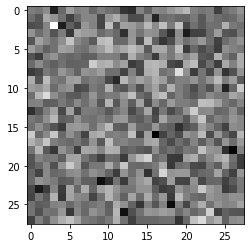

In [24]:
generator = make_generator_model()

noise=tf.random.normal([1, 100])
# label=Input(shape=(1,))
generated_image=generator([noise, 1])
# print(generated_image.shape)

plt.imshow(generated_image[0, :, :], cmap='gray')

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

#### Discriminator

In [19]:
def make_discrimiator_model():
    model=tf.keras.Sequential()
    model.add(Dense(128, input_shape=(img_dim,)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [12]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

#### Conditional D model

$x$ and $y$ are presented as inputs

In [20]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = layers.Embedding(num_classes, img_dim)(label_d)
label_embedding_d = layers.Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

#### Conditional model visualization

In [21]:
# prints a summary representation of your model
discriminator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           embedding_2[0][0]                
_______________________________________________________________________________________

### 3. Compile model

#### Compile discriminator

In [22]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### Combined network

In [23]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [24]:
# prints a summary representation of your model
d_g.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            273441      functional_1[0][0]    

### 4. Fit model


epoch = 1/100, d_loss=0.697, g_loss=0.904                                                                                                     


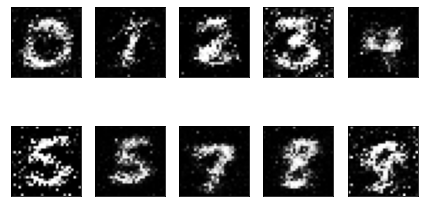

epoch = 2/100, d_loss=0.682, g_loss=0.843                                                                                                     
epoch = 3/100, d_loss=0.697, g_loss=0.872                                                                                                     
epoch = 4/100, d_loss=0.681, g_loss=0.816                                                                                                     
epoch = 5/100, d_loss=0.672, g_loss=0.820                                                                                                     
epoch = 6/100, d_loss=0.686, g_loss=0.833                                                                                                     
epoch = 7/100, d_loss=0.684, g_loss=0.835                                                                                                     
epoch = 8/100, d_loss=0.671, g_loss=0.832                                                                                                     

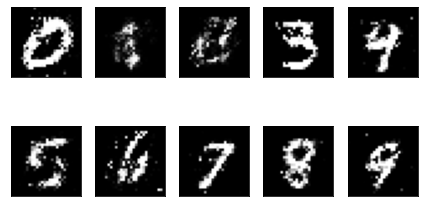

epoch = 12/100, d_loss=0.670, g_loss=0.845                                                                                                     
epoch = 13/100, d_loss=0.642, g_loss=0.895                                                                                                     
epoch = 14/100, d_loss=0.682, g_loss=0.846                                                                                                     
epoch = 15/100, d_loss=0.645, g_loss=0.843                                                                                                     
epoch = 16/100, d_loss=0.626, g_loss=0.863                                                                                                     
epoch = 17/100, d_loss=0.624, g_loss=0.842                                                                                                     
epoch = 18/100, d_loss=0.651, g_loss=0.875                                                                                              

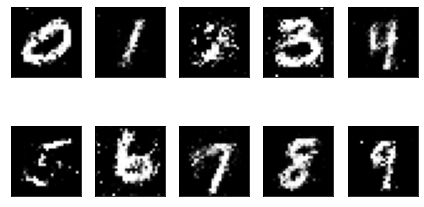

epoch = 22/100, d_loss=0.652, g_loss=0.868                                                                                                     
epoch = 23/100, d_loss=0.643, g_loss=0.898                                                                                                     
epoch = 24/100, d_loss=0.684, g_loss=0.845                                                                                                     
epoch = 25/100, d_loss=0.684, g_loss=0.812                                                                                                     
epoch = 26/100, d_loss=0.643, g_loss=0.822                                                                                                     
epoch = 27/100, d_loss=0.655, g_loss=0.830                                                                                                     
epoch = 28/100, d_loss=0.645, g_loss=0.826                                                                                              

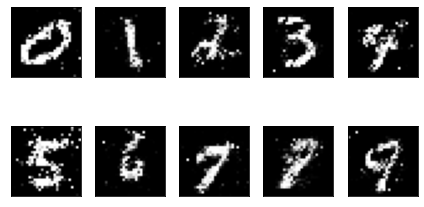

epoch = 32/100, d_loss=0.673, g_loss=0.850                                                                                                     
epoch = 33/100, d_loss=0.673, g_loss=0.810                                                                                                     
epoch = 34/100, d_loss=0.670, g_loss=0.863                                                                                                     
epoch = 35/100, d_loss=0.674, g_loss=0.837                                                                                                     
epoch = 36/100, d_loss=0.673, g_loss=0.832                                                                                                     


KeyboardInterrupt: 

In [25]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

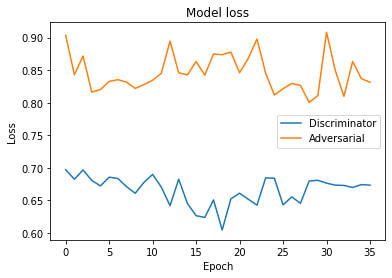

In [26]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()